In [2]:
import impaintingLib as imp
import torch 
import matplotlib.pyplot as plt
import numpy as np 
from torchvision import transforms


def plot(image):
    image = torch.clip(image,0,1)
    plt.figure(figsize=(4,3))
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')

torch.Size([3, 64, 64])


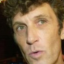

torch.Size([3, 64, 64])


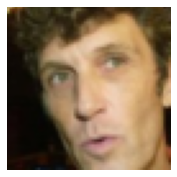

In [3]:
trainloader, testloader = imp.data.getFaces(shuffle=False,doNormalize=False)
imgs, _ = next(iter(testloader))

img = imgs[0]
print(img.shape)

img = transforms.ToPILImage()(img)
img.show()
img = transforms.ToTensor()(img)
print(img.shape)

plot(img)

torch.Size([3, 64, 64])
torch.Size([1, 64, 64])
tensor([[255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        ...,
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.]])


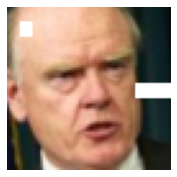

In [4]:
c, h, w = img.shape

w11 = 5
h11 = 6
        
w22 = 50
h22 = 30

print(img.shape)
        
# cutouts = torch.empty((1, h, w), dtype=img.dtype, device=img.device)
cutouts = torch.full((1,h,w),255, dtype=img.dtype, device=img.device)
cutouts[:, h11:h11 + h11, w11:w11 + w11] = 0
cutouts[:, h22:h22 + h11, w22:w22 + w22] = 0

print(cutouts.shape)

res = torch.cat((img,cutouts),0)
plot(res)

print(res[-1])

In [5]:
imgs, _ = next(iter(testloader))

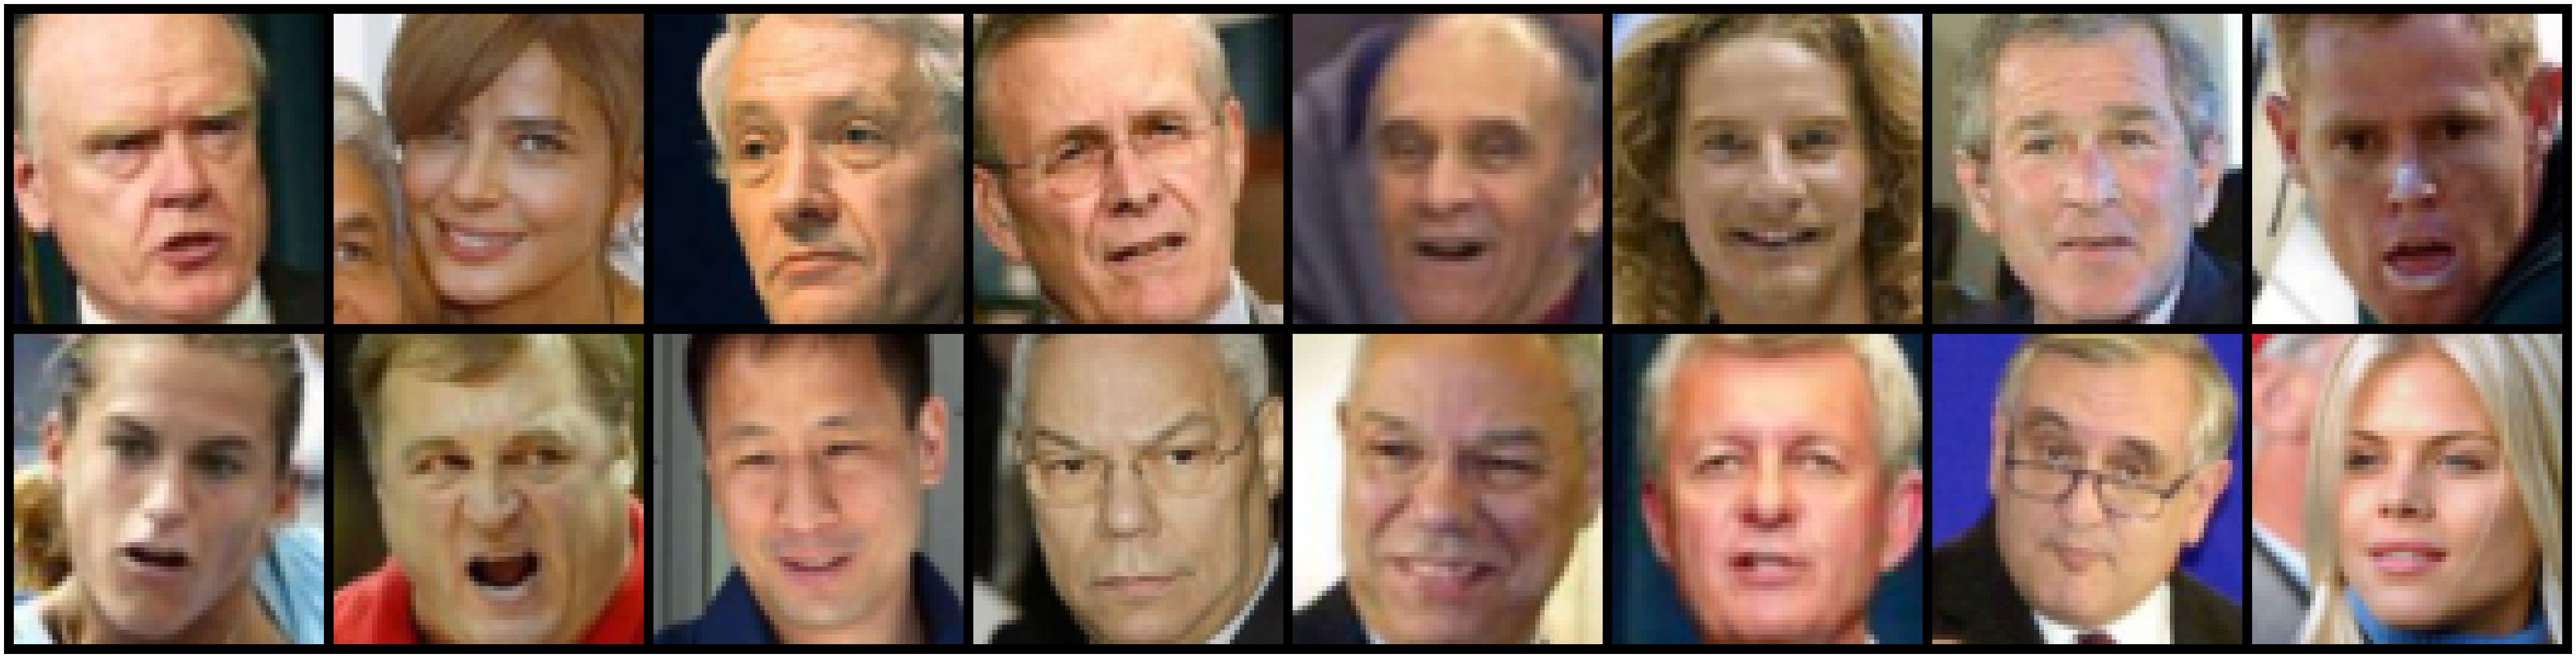

In [6]:
visu = imp.utils.Visu()
visu.plot_img(imgs)

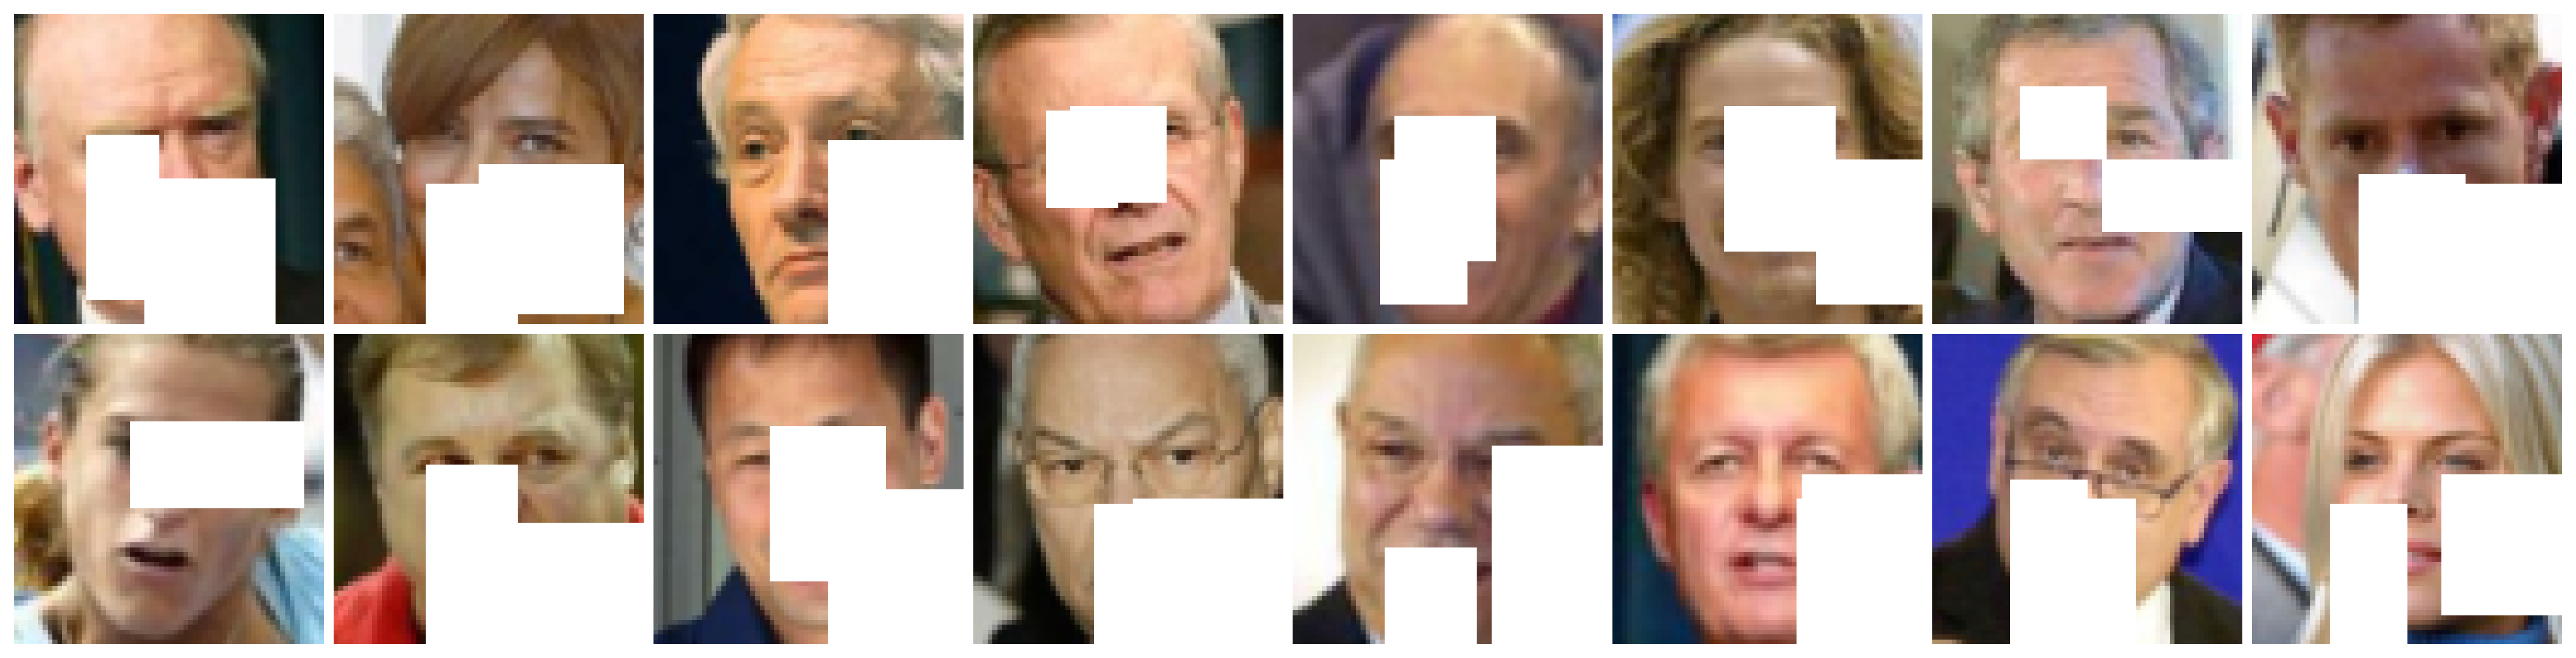

In [7]:
alter = imp.mask.Alter()
imgs = alter.squareMask(imgs)
visu.plot_img(imgs)

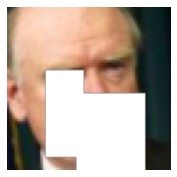

In [8]:
img = imgs[0]
plot(img)

torch.Size([3, 64, 64])
torch.Size([3, 64, 64])


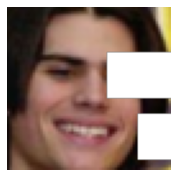

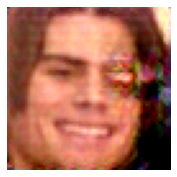

In [48]:
import impaintingLib as imp
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image

def plot(image):
    image = torch.clip(image,0,1)
    plt.figure(figsize=(4,3))
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = imp.model.UNet().to(device)
model = imp.model.AutoEncoder().to(device)
model = imp.process.model_load(model,"Autoencode_Perceptualvgg_+_L1_+_Totalvar_Epoch30")

alterFunc = imp.mask.Alter(min_cut=4, max_cut=60, seed=1).squareMask
# trainloader, testloader = imp.data.getFaces(shuffle=False)
# imgs, _ = next(iter(testloader))


with Image.open("./data/lfw/AJ_Lamas/AJ_Lamas_0001.jpg") as image:
    resize = (120, 120)
    crop   = (64 , 64 )
    transformations = transforms.Compose([
         transforms.Resize(resize), 
         transforms.CenterCrop(crop),
         transforms.ToTensor()
    ])
    image = transformations(image)
    print(image.shape)
    
imgs = image.view(1,3,64,64)
imgs = imgs.to(device)
imgs = alterFunc(imgs)
img = imgs[0].cpu().detach()
plot(img)

imgs = model(imgs).cpu()
img = imgs[0].cpu().detach()
print(img.shape)
#img = imp.data.inv_normalize(img)

plot(img)
save_image(img, './savedImages/yanis/31.jpg')

0
0
1
lumi


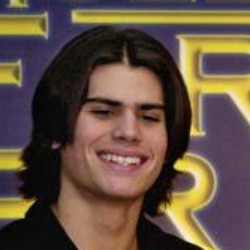

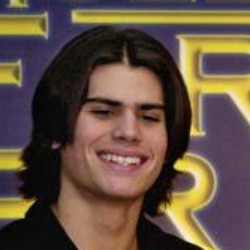

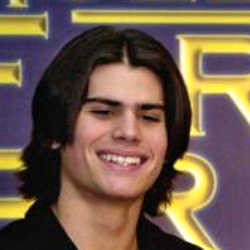

In [53]:
from PIL import Image, ImageEnhance
import numpy as np
import math
import random

def zoom(img,factor=0):
    size = (width, height) = (img.size)

    # Si on ne lui donne pas d'arg alors c'est aléatoire
    if factor < 1 :
        (mu,sigma) = (1,3)
        factor = abs(factor)
        factor = np.random.normal(mu, sigma)

    (left, upper, right, lower) = (factor, factor, height-factor, width-factor)
    img = img.crop((left, upper, right, lower))
    img = img.resize(size)
    return img

def rotation(img):
    (mu,sigma) = (1,1)
    factor = np.random.normal(mu, sigma)
    factor = abs(factor)
    img = img.rotate(factor)
    #img = zoom(img,20)
    return img

def mirror(img):
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    return img

def enhance(img,enhancer):
    (mu,sigma) = (1,0.15)
    factor = np.random.normal(mu, sigma)
    #print(factor)
    img = enhancer.enhance(factor)
    return img

def lumi(img):
    func = ImageEnhance.Brightness(img)
    return enhance(img,func)

def contrast(img):
    func = ImageEnhance.Contrast(img)
    return enhance(img,func)

def color(img):
    func = ImageEnhance.Color(img)
    return enhance(img,func)

def sharpness(img):
    func = ImageEnhance.Sharpness(img)
    return enhance(img,func)

def randomTransfo(imgs):
    (mu,sigma) = (1.3,0.2)
    
    for k,img in enumerate(imgs) : 
        nbTransfo = np.random.normal(mu, sigma)
        nbTransfo = abs(nbTransfo)
        nbTransfo = int(nbTransfo)

        print(nbTransfo)
        transfos = [zoom, rotation, mirror, lumi, contrast, color, sharpness]
        for i in range(nbTransfo):
            func = random.choice(transfos)
            print(func. __name__)
            transfos.remove(func)
            imgs[k] = func(img.copy())

    return imgs

path = "./data/lfw/AJ_Lamas/AJ_Lamas_0001.jpg"

with Image.open(path) as img:
    imgs = [img,img,img]
    imgs = randomTransfo(imgs)
    imgs[0].show()
    imgs[1].show()
    imgs[2].show()
    

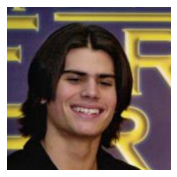

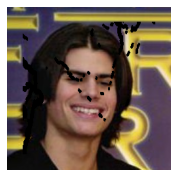

In [4]:
import impaintingLib as imp
from PIL import Image, ImageEnhance
import torch
from torchvision import transforms

path = "./data/lfw/AJ_Lamas/AJ_Lamas_0001.jpg"

def inv_normalize(x):
    transfo = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                   std=[1/0.229, 1/0.224, 1/0.225])
    return transfo(x)
        
with Image.open(path) as img:
    img = transforms.ToTensor()(img)
    c,w,h = img.shape
    imgs = torch.empty((2, c, h, w), dtype=img.dtype, device=img.device)
    imgs[0] = img
    imgs[1] = img
    
    plot(imgs[0])
    imgs = imp.mask.Alter(min_cut=15, max_cut=85, seed=0).irregularMask(imgs)
    plot(imgs[0])

Loading BigGAN model biggan-deep-256 from cache at /opt/app-root/src/.pytorch_pretrained_biggan/e7d036ee69a83e83503c46902552573b27d856eaf6b8b84252a63a715dce7501.aec5caf3e5c5252b8857d6bb8adefa8d1d6092a8ba6c9aaed1e6678f8a46be43


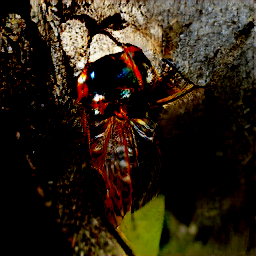

In [7]:
import torch
from pytorch_pretrained_gans import make_gan

# Sample a class-conditional image from BigGAN with default resolution 256
G = make_gan(gan_type='biggan')  # -> nn.Module
y = G.sample_class(batch_size=1)  # -> torch.Size([1, 1000])
z = G.sample_latent(batch_size=1)  # -> torch.Size([1, 128])
x = G(z=z, y=y)  # -> torch.Size([1, 3, 256, 256])

x = torch.clip(x,0,1)
x = transforms.ToPILImage()(x[0])
x.show()

Loaded pretrained GAN weights (iteration: 200000.0)


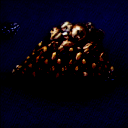

In [9]:
G = make_gan(gan_type='selfconditionedgan', model_name='self_conditioned')  # -> nn.Module
y = G.sample_class(batch_size=1)  # -> torch.Size([1, 1000])
z = G.sample_latent(batch_size=1)  # -> torch.Size([1, 256])
x = G(z=z, y=y)  # -> torch.Size([1, 3, 128, 128])

x = torch.clip(x,0,1)
x = transforms.ToPILImage()(x[0])
x.show()

In [16]:
import matplotlib.pyplot as plt
import numpy as np 

def plot(image):
    image = torch.clip(image,0,1)
    plt.figure(figsize=(4,3))
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')

torch.Size([32, 3, 64, 64])
tensor(False)
<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>


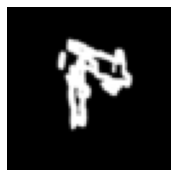

In [69]:
from torchvision.datasets.folder import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch

resize   = (64 , 64)
path = "data/masks"

transformations = [
         transforms.Resize(resize), 
         transforms.ToTensor()
]

process = transforms.Compose(transformations)
dataset = ImageFolder(path, process)
masks   = DataLoader(dataset, batch_size=32, 
                              shuffle=True, 
                              num_workers=2)
x,_ = next(iter(masks))
print(x.shape)
plot(x[0])

print((x[0] > 1.).any())
print(type(iter(masks)))

In [2]:
import impaintingLib as imp
import torch 
import matplotlib.pyplot as plt
import numpy as np 
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

trainloader, testloader = imp.data.getFaces(shuffle=False,doNormalize=False)
imgs, _ = next(iter(testloader))
imgs = imgs[:10]
imgs = imgs.to(device)

alter = imp.mask.Alter()
altered = alter.irregularMask(imgs)

models[0].load_state_dict(torch.load('modelSave/unet_3channels.pth'))
models[1].load_state_dict(torch.load('modelSave/pixelshuffle_3channels.pth'))
imp.process.test(models, testloader, alter=alterFunc)

for i,img in enumerate(imgs) : 
    img = transforms.ToPILImage()(img)
    path = "./savedImages/yanis/original{}.jpg"
    img.save(path.format(str(i)))
    
    
    
    
    
    img = altered[i]
    img = transforms.ToPILImage()(img)
    path = "./savedImages/yanis/altered{}.jpg"
    img.save(path.format(str(i)))